[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ashu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ashu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Model training complete and saved as fake_news_detector.pkl


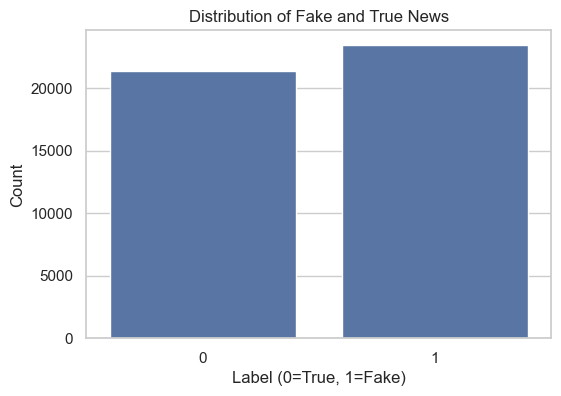

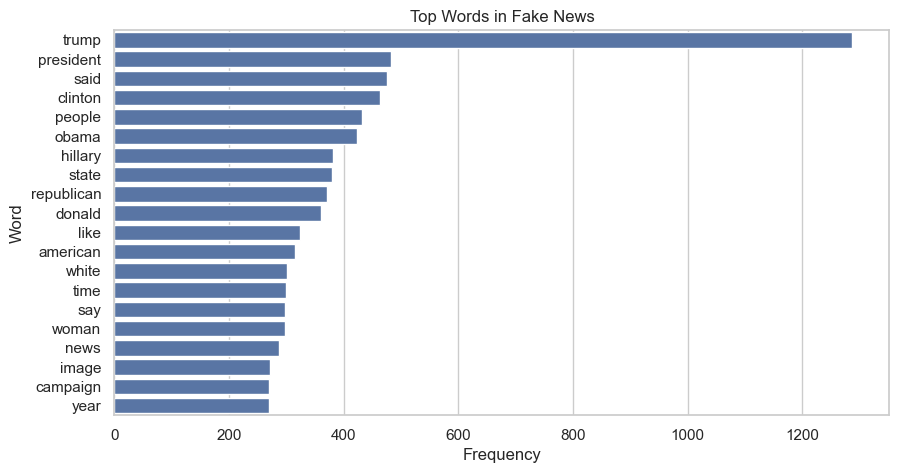

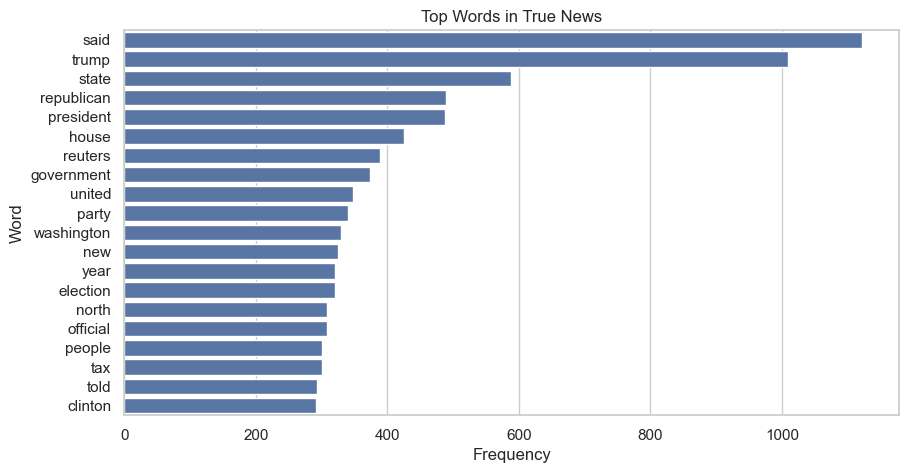

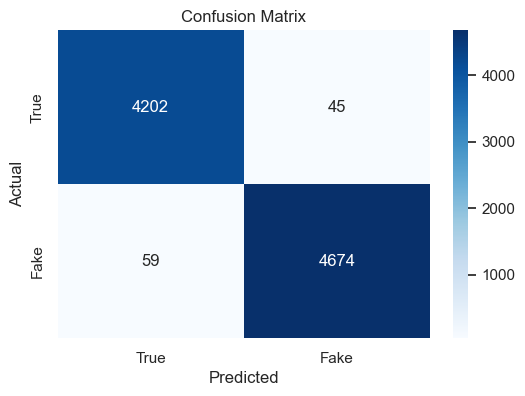

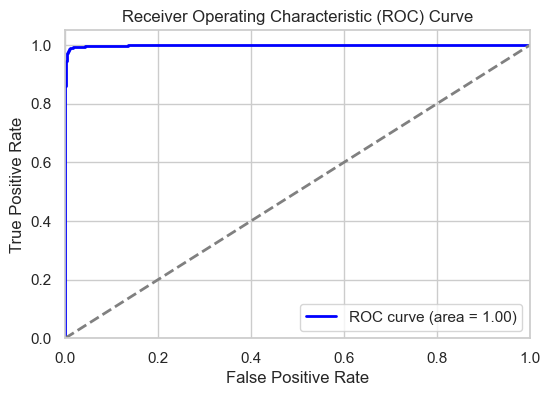

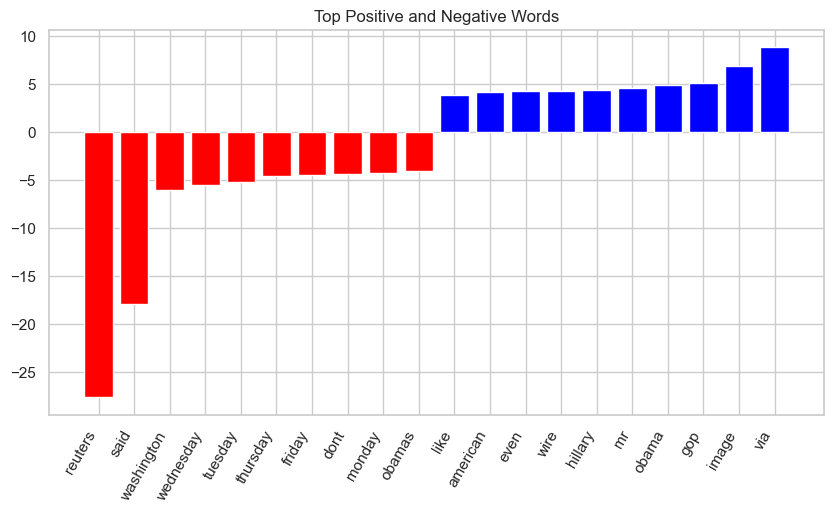

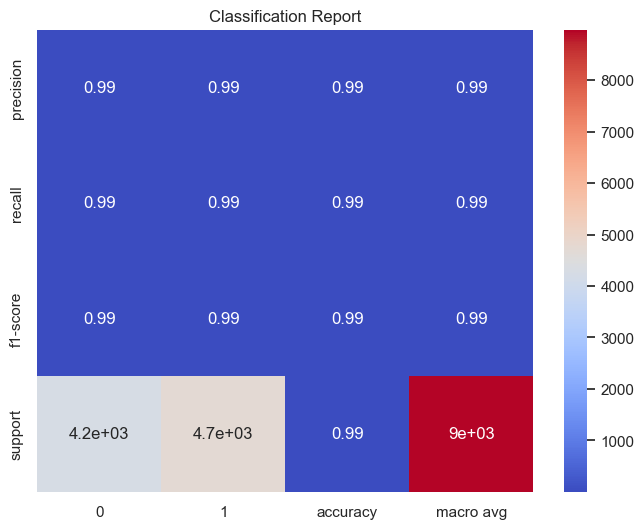

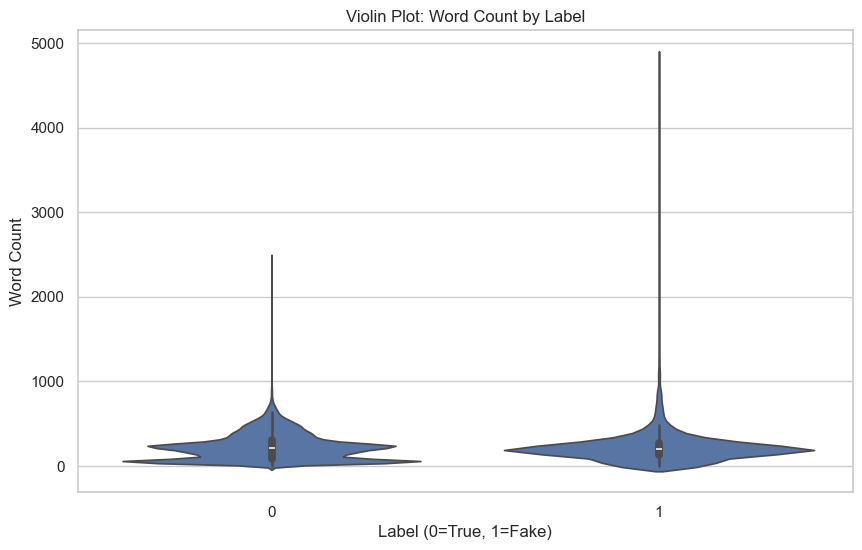

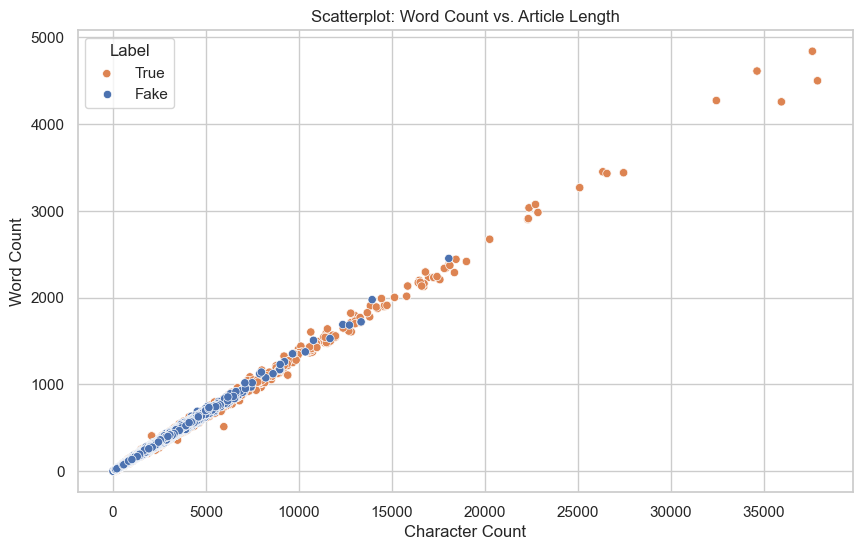

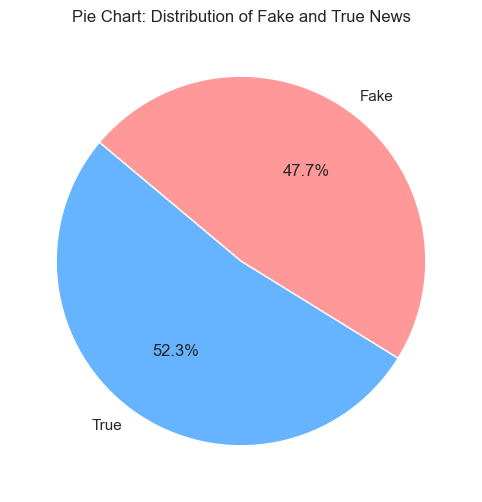

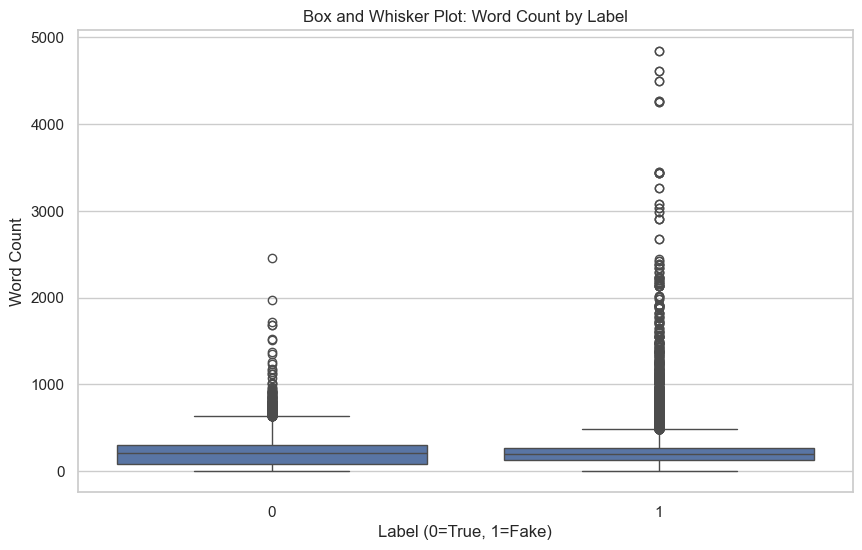

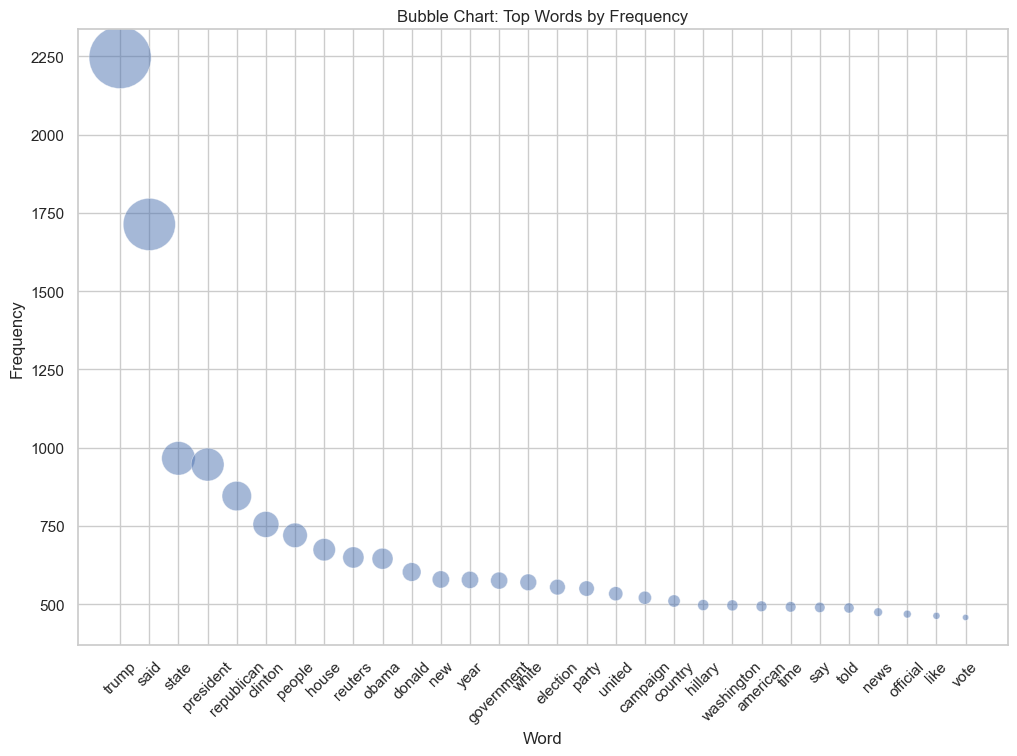

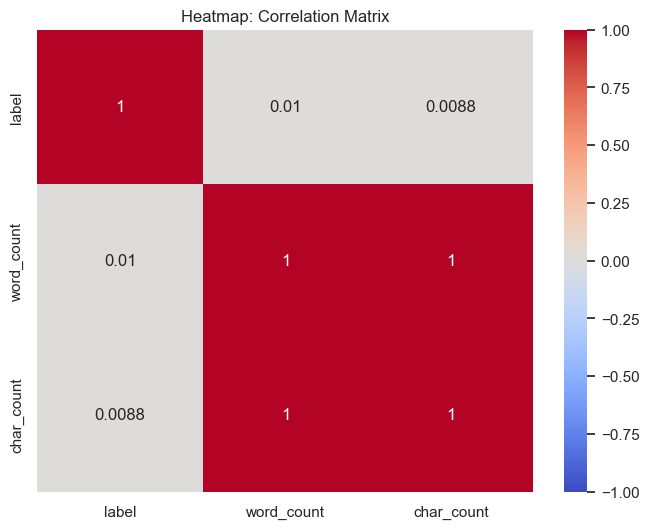

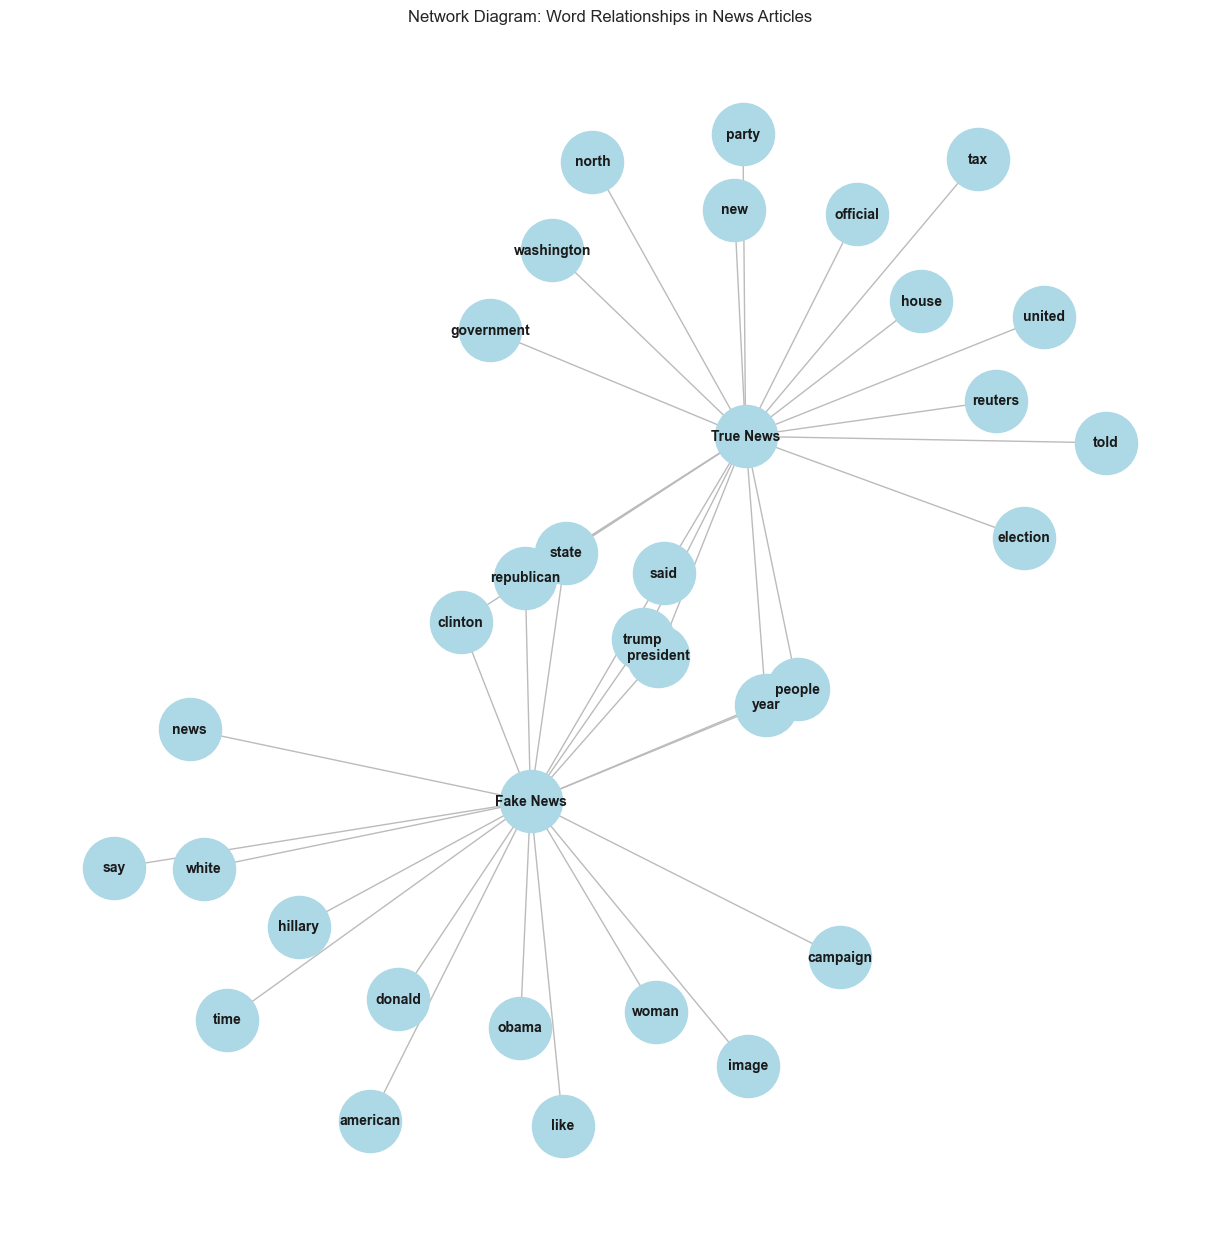

<Figure size 1600x1000 with 0 Axes>

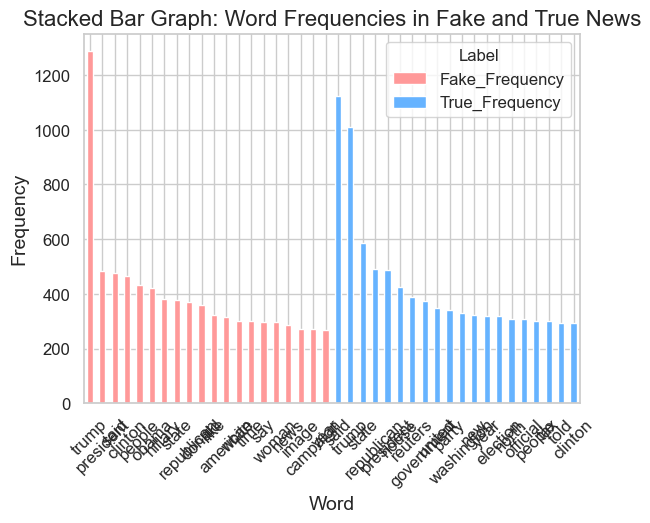

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  \
0  December 31, 2017      1   
1  December 31, 2017      1   
2  December 30, 2017      1   
3  December 29, 2017      1   
4  December 25, 2017      1   

                                          clean_text  word_count  char_count  
0  donald tr

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from collections import Counter
import plotly.graph_objects as go
import networkx as nx

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load datasets
fake_df = pd.read_csv('fake.csv')
true_df = pd.read_csv('true.csv')

# Add a label column: 1 for fake, 0 for true
fake_df['label'] = 1
true_df['label'] = 0

# Concatenate the datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

# Preprocess the text data
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    return ' '.join(lemmatized_tokens)

df['clean_text'] = df['text'].apply(preprocess_text)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

# Create a pipeline with TfidfVectorizer and LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('lr', LogisticRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Save the model
joblib.dump(pipeline, 'fake_news_detector.pkl')

print("Model training complete and saved as fake_news_detector.pkl")

# Set plot style
sns.set(style='whitegrid')

# Visualization: Distribution of fake and true news (Bar Graph)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution of Fake and True News')
plt.xlabel('Label (0=True, 1=Fake)')
plt.ylabel('Count')
plt.show()

# Function to get top N words
def get_top_n_words(corpus, n=None):
    vec = TfidfVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Top words in fake news
top_fake_words = get_top_n_words(df[df['label'] == 1]['clean_text'], 20)
top_true_words = get_top_n_words(df[df['label'] == 0]['clean_text'], 20)

# Visualization: Top words in fake news (Bar Graph)
plt.figure(figsize=(10, 5))
fake_words_df = pd.DataFrame(top_fake_words, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=fake_words_df)
plt.title('Top Words in Fake News')
plt.show()

# Visualization: Top words in true news (Bar Graph)
plt.figure(figsize=(10, 5))
true_words_df = pd.DataFrame(top_true_words, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=true_words_df)
plt.title('Top Words in True News')
plt.show()

# Visualization: Confusion matrix (Heatmap)
y_pred = pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualization: ROC Curve
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Visualization: Feature importance (Bar Graph)
vectorizer = pipeline.named_steps['tfidf']
log_reg = pipeline.named_steps['lr']
feature_names = vectorizer.get_feature_names_out()
coefficients = log_reg.coef_.flatten()

# Top positive and negative words
top_positive_coefficients = np.argsort(coefficients)[-10:]
top_negative_coefficients = np.argsort(coefficients)[:10]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

# Plot top coefficients
plt.figure(figsize=(10, 5))
colors = ['red' if c < 0 else 'blue' for c in coefficients[top_coefficients]]
plt.bar(np.arange(20), coefficients[top_coefficients], color=colors)
feature_names_top = [feature_names[i] for i in top_coefficients]
plt.xticks(np.arange(20), feature_names_top, rotation=60, ha='right')
plt.title('Top Positive and Negative Words')
plt.show()

# Visualization: Classification report (Heatmap)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='coolwarm')
plt.title('Classification Report')
plt.show()

# Visualization: Violin plot
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.violinplot(x='label', y='word_count', data=df)
plt.title('Violin Plot: Word Count by Label')
plt.xlabel('Label (0=True, 1=Fake)')
plt.ylabel('Word Count')
plt.show()

# Visualization: Scatterplot
df['char_count'] = df['clean_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='char_count', y='word_count', hue='label', data=df)
plt.title('Scatterplot: Word Count vs. Article Length')
plt.xlabel('Character Count')
plt.ylabel('Word Count')
plt.legend(title='Label', labels=['True', 'Fake'])
plt.show()

# Visualization: Pie chart
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(label_counts, labels=['True', 'Fake'], autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
plt.title('Pie Chart: Distribution of Fake and True News')
plt.show()

# Visualization: Box and Whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', data=df)
plt.title('Box and Whisker Plot: Word Count by Label')
plt.xlabel('Label (0=True, 1=Fake)')
plt.ylabel('Word Count')
plt.show()

# Visualization: Bubble chart
top_words = get_top_n_words(df['clean_text'], 30)
words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 8))
sns.scatterplot(data=words_df, x='Word', y='Frequency', size='Frequency', legend=False, sizes=(20, 2000), alpha=0.5)
plt.title('Bubble Chart: Top Words by Frequency')
plt.xticks(rotation=45)
plt.show()

# Visualization: Heatmap
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap: Correlation Matrix')
plt.show()

# Visualization: Network diagram
G = nx.Graph()

for index, row in fake_words_df.iterrows():
    G.add_edge('Fake News', row['Word'], weight=row['Frequency'])
for index, row in true_words_df.iterrows():
    G.add_edge('True News', row['Word'], weight=row['Frequency'])

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, font_weight='bold', edge_color='#BBBBBB')
plt.title('Network Diagram: Word Relationships in News Articles')
plt.show()

# Visualization: Stacked bar graph
stacked_bar_data = pd.concat([
    fake_words_df.rename(columns={'Frequency': 'Fake_Frequency'}),
    true_words_df.rename(columns={'Frequency': 'True_Frequency'})
]).fillna(0)

plt.figure(figsize=(16, 10))  # Increase figure size
ax = stacked_bar_data.set_index('Word').plot(kind='bar', stacked=True, color=['#ff9999', '#66b3ff'])
plt.title('Stacked Bar Graph: Word Frequencies in Fake and True News', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Label', fontsize=12)
plt.show()

# True table form
print(df.head())

# Save the model again for completeness
joblib.dump(pipeline, 'fake_news_detector_with_visuals.pkl')
print("Model training complete and saved as fake_news_detector_with_visuals.pkl")
